In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import os
import random

In [205]:
real_data = np.load("../result/real_data.npy")
generated_data = np.load("../result/generated_data.npy")

In [206]:
real_data.shape, generated_data.shape

((5, 30, 48), (5, 30, 48))

In [191]:
test_mean = 10.192975913242009
test_std = 4.106242041668793
real_data = real_data * test_std + test_mean
generated_data = generated_data * test_std + test_mean

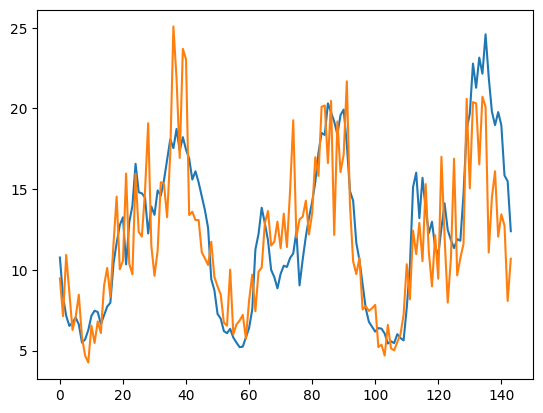

In [212]:
plt.plot(real_data[0, :3].flatten())
plt.plot(generated_data[0, :3].flatten())

In [211]:
from sklearn.metrics import mean_squared_error
print(real_data[0].flatten().mean())
print(mean_squared_error(real_data[0].flatten(), generated_data[0].flatten()))

12.331278588981947
8.990010636996574


In [2]:
seed = 22
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Data Construct

In [2]:
from sklearn.preprocessing import StandardScaler
file_path = "../data/UKDA_2013_clean.csv"
original_data = pd.read_csv(file_path)

aggregation_num = 20
aggregated_data = pd.DataFrame()
aggregated_data["time"] = pd.to_datetime(original_data["time"])
for i in range((original_data.shape[1]-2)//aggregation_num):
    temp_data = original_data.iloc[:, (1+i*aggregation_num):(1+(i+1)*aggregation_num)].sum(axis=1)
    temp_name = "user_" + str(i+1)
    aggregated_data[temp_name] = temp_data

In [34]:
test_one = torch.tensor(aggregated_data.iloc[:48*30, 1].values.T.reshape(3, 10, 48))
test_one.shape

torch.Size([3, 10, 48])

In [36]:
test_two = torch.cat((test_one, test_one), axis=-1)
test_two.shape

torch.Size([3, 10, 96])

In [42]:
repeat_type = "repeat"
mode = "test"
"../result/real_data_"+mode+"_"+repeat_type+".npy"

'../result/real_data_test_repeat.npy'

In [19]:
np.concatenate((test_two, test_one), axis=1).shape

(30, 144)

In [23]:
test_two.reshape(-1,48)

array([[5.498, 4.748, 4.959, ..., 7.817, 6.863, 7.727],
       [5.498, 4.748, 4.959, ..., 7.817, 6.863, 7.727],
       [6.819, 5.188, 4.252, ..., 8.292, 7.364, 6.74 ],
       ...,
       [4.87 , 6.21 , 4.25 , ..., 5.538, 5.869, 6.044],
       [6.588, 4.015, 3.338, ..., 8.616, 6.592, 7.77 ],
       [6.588, 4.015, 3.338, ..., 8.616, 6.592, 7.77 ]])

In [13]:
test_one.shape

(30, 48)

In [4]:
file_path = "../data/UKDA_2013_clean.csv"
original_data = pd.read_csv(file_path)

In [163]:
from sklearn.preprocessing import StandardScaler
file_path = "../data/UKDA_2013_clean.csv"
all_data = pd.read_csv(file_path)
test = all_data.iloc[:, -51:-1].sum(axis=1)

aggregated_data = pd.DataFrame()
aggregated_data["time"] = pd.to_datetime(all_data["time"])
for i in range((all_data.shape[1]-2)//50):
    temp_data = all_data.iloc[:, (1+i*50):(1+(i+1)*50)].sum(axis=1)
    temp_name = "user_" + str(i+1)
    aggregated_data[temp_name] = temp_data

scaler = StandardScaler().fit(aggregated_data.iloc[:, 1:])    
#     # scaler = StandardScaler().fit(aggregated_data)
new_test = (test - scaler.mean_[2]) / scaler.scale_[2]

test_data = new_test[:48*30].values.reshape(-1, 48)
test_condition = test_data[14].reshape(1, -1).repeat(30, axis=0)

In [134]:
test.values.reshape(-1, 48).shape

(365, 48)

In [4]:
aggregation_num = 10
aggregated_data = pd.DataFrame()
aggregated_data["time"] = pd.to_datetime(original_data["time"])
for i in range((original_data.shape[1]-2)//aggregation_num):
    temp_data = original_data.iloc[:, (1+i*aggregation_num):(1+(i+1)*aggregation_num)].sum(axis=1)
    temp_name = "user_" + str(i+1)
    aggregated_data[temp_name] = temp_data

In [5]:
aggregated_data["month"] = [aggregated_data["time"][i].month for i in range(aggregated_data.shape[0])]
aggregated_data["day"] = [aggregated_data["time"][i].day for i in range(aggregated_data.shape[0])]
aggregated_data["hour"] = [aggregated_data["time"][i].hour for i in range(aggregated_data.shape[0])]
aggregated_data["minute"] = [aggregated_data["time"][i].minute for i in range(aggregated_data.shape[0])]
month_index = aggregated_data["month"].value_counts(sort=False)//48

condition_data = pd.DataFrame()
condition_data["time"] = aggregated_data["time"]
condition_df = aggregated_data.groupby(["month", "day", "hour", "minute"]).agg("mean").round(3)
for user in aggregated_data.columns[1:-4]:
    user_data = np.array([])
    for month in month_index.index:
        days = month_index[month]
        temp_data = condition_df[user].loc[month, 14, :, :].values.reshape(1,-1)
        month_data = temp_data.repeat(days, axis=0)
        user_data = np.append(user_data, month_data.flatten())
    condition_data[user] = user_data

In [35]:
test_num = 10
test_day = 30
mode = "test"
all_origin = aggregated_data.iloc[:, 1:-4].values.T.reshape(82, -1, 48)
all_condition = condition_data.iloc[:, 1:].values.T.reshape(82, -1, 48)

if mode == "train":
    origin = np.concatenate((all_origin[:-test_num].reshape(-1, 48), all_origin[-test_num:, :-test_day, :].reshape(-1, 48)), axis=0)
    condition = np.concatenate((all_condition[:-test_num].reshape(-1, 48), all_condition[-test_num:, :-test_day, :].reshape(-1, 48)), axis=0)
elif mode == "test":
    origin = all_origin[-test_num:, -test_day:, :].reshape(-1,48)
    condition = all_condition[-test_num:, -test_day:, :].reshape(-1,48)

In [52]:
test_data = aggregated_data.iloc[:, 1:-4]
test_data.head()

,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9,user_10,...,user_73,user_74,user_75,user_76,user_77,user_78,user_79,user_80,user_81,user_82
0,3.819,1.679,2.634,2.406,1.889,2.582,3.240,2.091,2.283,1.816,...,1.666,1.318,4.034,4.450,3.110,1.436,1.892,1.195,2.294,2.577
1,3.372,1.376,2.847,2.455,1.800,1.708,3.060,2.159,2.133,1.855,...,1.400,1.079,2.896,4.187,2.734,1.531,1.517,1.114,2.031,2.297
2,2.827,2.132,2.218,2.454,1.429,1.264,2.523,1.801,1.886,1.816,...,1.259,1.078,2.446,4.360,2.562,1.402,1.901,1.139,1.777,3.454
3,2.809,1.628,1.640,1.861,1.289,1.020,2.069,1.257,1.837,1.842,...,1.366,1.340,2.665,4.347,2.387,1.831,1.814,1.171,1.534,3.725
4,2.927,1.952,1.495,1.940,1.202,1.201,1.806,1.479,1.446,1.595,...,1.121,0.607,2.929,4.546,2.174,1.877,1.215,0.866,1.082,2.241


In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(test_data)

In [64]:
new_test_data = pd.DataFrame(scaler.transform(test_data))

In [66]:
aggregated_data.iloc[:, 1:-4] = scaler.transform(test_data)

In [76]:
scaler.mean_.shape

(82,)

In [15]:
aggregated_data.iloc[:, 1:-4].values.T.reshape(82, -1, 48)[1]

array([[1.679, 1.376, 2.132, ..., 2.41 , 1.949, 2.687],
       [1.994, 1.504, 1.57 , ..., 3.438, 2.83 , 2.153],
       [2.393, 2.541, 1.732, ..., 2.226, 2.165, 2.003],
       ...,
       [3.393, 2.7  , 2.943, ..., 2.068, 2.207, 2.988],
       [2.817, 2.466, 1.894, ..., 2.824, 2.985, 1.97 ],
       [1.605, 2.129, 1.889, ..., 3.933, 2.353, 1.85 ]])

In [401]:
origin = aggregated_data.iloc[:, 1:-4].values.T.reshape(-1,48)
condition = condition_data.iloc[:, 1:].values.T.reshape(-1,48)

In [450]:
condition.shape

(29930, 48)

In [452]:
torch.from_numpy(origin).type(torch.float32)

tensor([[3.8190, 3.3720, 2.8270,  ..., 5.4070, 4.9140, 5.0400],
        [4.8250, 3.6840, 2.6820,  ..., 4.8540, 4.5340, 4.5870],
        [2.5680, 2.4770, 2.4180,  ..., 4.0810, 3.4280, 3.5900],
        ...,
        [2.3260, 2.2620, 1.2240,  ..., 2.2090, 2.3060, 1.8340],
        [1.4660, 1.5350, 1.7180,  ..., 2.1710, 1.9040, 1.9230],
        [1.2420, 1.1930, 0.8510,  ..., 1.7180, 1.5670, 1.3540]])

In [455]:
class Dataset_UKDA(Dataset):
    def __init__(self, file_path, aggregation_num):
        origin, condition = get_dataset(file_path, aggregation_num)
        self.origin = torch.from_numpy(origin).type(torch.float32).unsqueeze(-1)
        self.condition = torch.from_numpy(condition).type(torch.float32).unsqueeze(-1)

    def __getitem__(self, index):
        return self.origin[index], self.condition[index]
    
    def __len__(self):
        return self.origin.shape[0]


def get_dataset(file_path, aggregation_num):
    original_data = pd.read_csv(file_path)

    aggregated_data = pd.DataFrame()
    aggregated_data["time"] = pd.to_datetime(original_data["time"])
    for i in range((original_data.shape[1]-2)//aggregation_num):
        temp_data = original_data.iloc[:, (1+i*aggregation_num):(1+(i+1)*aggregation_num)].sum(axis=1)
        temp_name = "user_" + str(i+1)
        aggregated_data[temp_name] = temp_data

    aggregated_data["month"] = [aggregated_data["time"][i].month for i in range(aggregated_data.shape[0])]
    aggregated_data["day"] = [aggregated_data["time"][i].day for i in range(aggregated_data.shape[0])]
    aggregated_data["hour"] = [aggregated_data["time"][i].hour for i in range(aggregated_data.shape[0])]
    aggregated_data["minute"] = [aggregated_data["time"][i].minute for i in range(aggregated_data.shape[0])]
    month_index = aggregated_data["month"].value_counts(sort=False)//48

    condition_data = pd.DataFrame()
    condition_data["time"] = aggregated_data["time"]
    condition_df = aggregated_data.groupby(["month", "day", "hour", "minute"]).agg("mean").round(3)
    for user in aggregated_data.columns[1:-4]:
        user_data = np.array([])
        for month in month_index.index:
            days = month_index[month]
            temp_data = condition_df[user].loc[month, 14, :, :].values.reshape(1,-1)
            month_data = temp_data.repeat(days, axis=0)
            user_data = np.append(user_data, month_data.flatten())
        condition_data[user] = user_data

    origin = aggregated_data.iloc[:, 1:-4].values.T.reshape(-1,48)
    condition = condition_data.iloc[:, 1:].values.T.reshape(-1,48)

    return origin, condition

In [456]:
test_path = "../data/UKDA_2013_clean.csv"
test_dataset = Dataset_UKDA(test_path, 10)

In [473]:
x, y = test_dataset[:10]

In [474]:
x.shape

torch.Size([10, 48, 1])

In [305]:
test_data = original_data.iloc[:, 1:3].values.T.reshape(-1,48)

In [306]:
test_data.shape

(730, 48)

### Model Define

In [464]:
class Timestep_Embedding(nn.Module):
    def __init__(self, embedding_dim):
        super(Timestep_Embedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.fc_1 = nn.Linear(embedding_dim, embedding_dim)
        self.fc_2 = nn.Linear(embedding_dim, embedding_dim)
        self.activation = nn.SiLU()

    def forward(self, t):
        x = self._embedding(t)
        x = self.fc_1(x)
        x = self.activation(x)
        x = self.fc_2(x)
        x = self.activation(x)
        return x
    
    def _embedding(self, t):
        t_seq = t.repeat(1, self.embedding_dim//2)
        frequency = torch.pow(10, torch.arange(self.embedding_dim//2) / (self.embedding_dim//2-1) * 4.0)
        emb_sin = torch.sin(t_seq * frequency)
        emb_cos = torch.cos(t_seq * frequency)
        embedding = torch.cat([emb_sin, emb_cos], dim=1)
        return embedding

def timestep_sample(noise_step, n):
    # 采样n个timestep用于训练模型，采用均匀分布
    time_steps = torch.randint(1, noise_step, (n,1))
    return time_steps

In [488]:
test_timestep = timestep_sample(50, 10)
test_timestep_embedding = Timestep_Embedding(32)
test_timestep_emb = test_timestep_embedding(test_timestep)
test_timestep.shape, test_timestep_emb.shape

(torch.Size([10, 1]), torch.Size([10, 32]))

In [467]:
class PE_Embedding(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(PE_Embedding, self).__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.fc = nn.Linear(self.input_dim, self.embedding_dim)

    def forward(self, x):
        data_length = x.shape[1]
        x = self.fc(x)
        x = x + self._position_encoding(data_length)
        return x

    def _position_encoding(self, data_length):
        encoding = torch.zeros((data_length, self.embedding_dim))
        position = torch.arange(data_length).unsqueeze(1)
        encoding[:, 0::2] = torch.sin( position / torch.pow(10000, torch.arange(0, self.embedding_dim, 2)/self.embedding_dim) )
        encoding[:, 1::2] = torch.cos( position / torch.pow(10000, torch.arange(1, self.embedding_dim, 2)/self.embedding_dim) )
        return encoding

In [480]:
# test_data = torch.randn((4,16, 1))
test_data, test_condition = test_dataset[:10]
test_pe_embedding = PE_Embedding(1, 32)
test_pe_emb = test_pe_embedding(test_data)
test_pe_emb.shape

torch.Size([10, 48, 32])

In [477]:
class Encoder_Layer(nn.Module):
    def __init__(self, embedding_dim, num_head, dropout):
        super(Encoder_Layer, self).__init__()
        self.embedding_dim = embedding_dim
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_head, dropout=dropout)
        self.fc_1 = nn.Linear(self.embedding_dim, self.embedding_dim//2)
        self.fc_2 = nn.Linear(self.embedding_dim//2, self.embedding_dim)
        self.activation = nn.ReLU()
        self.layer_norm_1 = nn.LayerNorm(self.embedding_dim)
        self.layer_norm_2 = nn.LayerNorm(self.embedding_dim)

    def forward(self, x):
        residual = x
        x, _ = self.attention(query=x, key=x, value=x)
        x = self.layer_norm_1(x+residual)
        residual = x
        x = self.fc_1(x)
        x = self.activation(x)
        x = self.fc_2(x)
        x = self.layer_norm_2(x+residual)
        return x

In [312]:
test_encoder = Encoder_Layer(32, 2, 0.3)
test_attention = test_encoder(test_pe_emb)
test_attention.shape

torch.Size([4, 16, 32])

In [478]:
class Condition_Embedding(nn.Module):
    def __init__(self, condition_input_dim, embedding_dim, num_head, num_layer, dropout=0.2):
        super(Condition_Embedding, self).__init__()
        self.pe_embedding = PE_Embedding(condition_input_dim, embedding_dim)
        self.encoder = nn.ModuleList([Encoder_Layer(embedding_dim, num_head, dropout) for _ in range(num_layer)])

    def forward(self, x):
        x = self.pe_embedding(x)
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
        return x

In [481]:
test_condition_embedding = Condition_Embedding(1, 32, 2, 4, 0.2)
test_condition_emb = test_condition_embedding(test_condition)
test_condition.shape, test_condition_emb.shape

(torch.Size([10, 48, 1]), torch.Size([10, 48, 32]))

In [482]:
class Residual_Block(nn.Module):
    def __init__(self, condition_input_dim, embedding_dim, num_head, num_layer, dropout):
        super(Residual_Block, self).__init__()
        self.fc_timestep = nn.Linear(embedding_dim, embedding_dim)
        self.fc_condition = nn.Linear(embedding_dim, embedding_dim)
        self.fc_output = nn.Linear(embedding_dim//2, embedding_dim)
        self.attention = nn.ModuleList([Encoder_Layer(embedding_dim, num_head, dropout) for _ in range(num_layer)])
        self.condtion_embbeding = Condition_Embedding(condition_input_dim, embedding_dim, num_head, num_layer, dropout)

    def forward(self, x, timestep_emb, condition):
        residual = x
        x = x + self.fc_timestep(timestep_emb.unsqueeze(1))
        for attention_layer in self.attention:
            x = attention_layer(x)
        
        condition_emb = self.condtion_embbeding(condition)
        x = x + self.fc_condition(condition_emb)
        
        x_1, x_2 = torch.chunk(x, 2, dim=-1)
        x = torch.sigmoid(x_1) * torch.tanh(x_2)
        x = self.fc_output(x)
        residual = residual + x

        return residual, x

In [491]:
test_residual_block = Residual_Block(1, 32, 2, 4, 0.2)
test_residual, test_skip = test_residual_block(test_pe_emb, test_timestep_emb, test_condition)
test_residual.shape, test_skip.shape

(torch.Size([10, 48, 32]), torch.Size([10, 48, 32]))

In [492]:
class Model(nn.Module):
    def __init__(self, input_dim, condition_input_dim, embedding_dim, num_head, num_layer, num_block, dropout):
        super(Model, self).__init__()
        self.pe_embedding = PE_Embedding(input_dim, embedding_dim)
        self.timestep_embedding = Timestep_Embedding(embedding_dim)
        self.residual_model = nn.ModuleList([Residual_Block(condition_input_dim, embedding_dim, num_head, num_layer, dropout) for _ in range(num_block)])
        # check dim !!!
        self.fc_input = nn.Linear(embedding_dim, embedding_dim)
        self.fc_concat = nn.Linear(embedding_dim, embedding_dim)
        self.fc_output = nn.Linear(embedding_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, x, timestep, conditon):
        timestep_emb = self.timestep_embedding(timestep)
        
        x = self.pe_embedding(x)
        x = self.fc_input(x)
        x = self.activation(x)

        skip = []
        for residual_layer in self.residual_model:
            x, skip_output = residual_layer(x, timestep_emb, conditon)
            skip.append(skip_output)

        x = torch.sum(torch.stack(skip), dim=0)
        x = self.fc_concat(x)
        x = self.activation(x)
        x = self.fc_output(x)

        return x     

In [493]:
test_model = Model(1, 1, 32, 2, 4, 4, 0.2)
test_noise_predicted = test_model(test_data, test_timestep, test_condition)
test_noise_predicted.shape

torch.Size([10, 48, 1])

In [539]:
class Diffusion():
    def __init__(self, noise_step, beta_start, beta_end, data_length, device):
        self.noise_step = noise_step
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.data_length = data_length
        self.device = device
        # 定义beta和对应的alpha
        self.beta = self.noise_schedule().to(self.device)
        self.alpha = 1 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def noise_schedule(self):
        betas = torch.linspace(self.beta_start, self.beta_end, self.noise_step)
        return betas

    def forward_process(self, x_0, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])
        sqrt_one_minus_alpha_hat = torch.sqrt(1-self.alpha_hat[t])
        #重参数技巧，通过正态分布采样然后变换得到加噪后的分布
        noise = torch.randn_like(x_0)
        x_t = sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * noise
        return x_t, noise
    
    def timestep_sample(self, n):
        # 采样n个timestep用于训练模型，采用均匀分布
        time_steps = torch.randint(1, self.noise_step, (n,1))
        return time_steps

    def sample(self, model, n, condition):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, self.data_length)).unsqueeze(-1).to(self.device)
            for i in reversed(range(1, self.noise_step)):
                t = (torch.ones(n)*i).long().unsqueeze(-1).to(self.device)
                # conditional sample
                predicted_noise = model(x, t, condition)
                alpha_t = self.alpha[t].unsqueeze(-1)
                alpha_hat_t = self.alpha_hat[t].unsqueeze(-1)
                # beta此处对应方差，也可以用beta_tilde表示
                beta_t = self.beta[t].unsqueeze(-1)
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha_t) * (x - (1-alpha_t)/torch.sqrt(1-alpha_hat_t) * predicted_noise) + torch.sqrt(beta_t) * noise
        model.train()
        # 此处可以根据数据情况，考虑是否添加数据归一化/反归一化的操作
        return x

In [540]:
test_diffusion = Diffusion(50, 0.0001, 0.2, 48, None)
_, test_noise = test_diffusion.forward_process(test_data[0], test_timestep[0])
test_noise.shape

torch.Size([48, 1])

In [542]:
test_diffusion.sample(test_model, 10, test_condition).shape

torch.Size([10, 48, 1])

In [516]:
test_timestep.shape

torch.Size([10, 1])

### Model Train